In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

In [2]:
import pandas as pd

all_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
all_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
names = ["name", "date", "genre", "url"]
names += ["f" + str(x) for x in range(19)]  # unused feature names

items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|', encoding='latin-1',
                    names=names)
# fix a missing value
items.fillna(value="01-Jan-1997", inplace=True)
items.head()

,name,date,genre,url,f0,f1,f2,f3,f4,f5,...,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18
1,Toy Story (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [5]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [6]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [7]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(all_ratings, test_size=0.2, random_state=0)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

print(user_id_train.head())
print(item_id_train.head())
print(rating_train.head())

print(len(ratings_train))
print(len(ratings_test))

10382     70
73171    215
30938    488
99310    916
58959    292
Name: user_id, dtype: int64
10382    298
73171    172
30938    210
99310    156
58959    197
Name: item_id, dtype: int64
10382    5
73171    4
30938    4
99310    5
58959    5
Name: rating, dtype: int64
80000
20000


In [8]:
from keras.layers import Input, Embedding, Flatten, Dense, Dropout, Lambda
from keras.layers.merge import dot, concatenate
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [9]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y = dot([user_vecs, item_vecs], axes=-1)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

In [10]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train])
print(initial_train_preds.shape)
initial_train_preds = initial_train_preds.reshape(80000)
print(initial_train_preds.shape)

(80000, 1)
(80000,)


In [11]:
# %load solutions/compute_errors.py
squared_differences = np.square(initial_train_preds - rating_train.values)
absolute_differences = np.abs(initial_train_preds - rating_train.values)

print("Random init MSE: %0.3f" % np.mean(squared_differences))
print("Random init MAE: %0.3f" % np.mean(absolute_differences))

# You may also use sklearn metrics to do so with less numpy engineering 
#from sklearn.metrics import mean_squared_error, mean_absolute_error
#
#print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
#print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))

Random init MSE: 13.732
Random init MAE: 3.531


In [12]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=6, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
1s - loss: 2.8650 - val_loss: 1.2961
Epoch 2/6
1s - loss: 0.9621 - val_loss: 0.8351
Epoch 3/6
1s - loss: 0.7796 - val_loss: 0.7842
Epoch 4/6
1s - loss: 0.7478 - val_loss: 0.7758
Epoch 5/6
1s - loss: 0.7350 - val_loss: 0.7691
Epoch 6/6
1s - loss: 0.7266 - val_loss: 0.7649
CPU times: user 15.8 s, sys: 5.95 s, total: 21.7 s
Wall time: 11.4 s


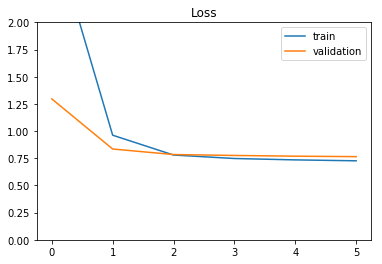

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.950
Final test MAE: 0.751


In [15]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.866
Final train MAE: 0.709


In [16]:
# %load solutions/deep_explicit_feedback_recsys.py
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = concatenate([user_vecs, item_vecs])
## Error 1: Dropout was too high, preventing any training
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)

## Error 2: output dimension was 2 where we predict only 1-d rating
## Error 3: tanh activation squashes the outputs between -1 and 1
## when we want to predict values between 1 and 5
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
## Error 4: A binary crossentropy loss is only useful for binary
## classification, while we are in regression (use mse or mae)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds = initial_train_preds.reshape(80000)

In [17]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=5, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
3s - loss: 1.0016 - val_loss: 0.7628
Epoch 2/5
2s - loss: 0.7524 - val_loss: 0.7543
Epoch 3/5
2s - loss: 0.7396 - val_loss: 0.7515
Epoch 4/5
2s - loss: 0.7308 - val_loss: 0.7479
Epoch 5/5
2s - loss: 0.7242 - val_loss: 0.7442
CPU times: user 20.1 s, sys: 9.43 s, total: 29.5 s
Wall time: 14.4 s


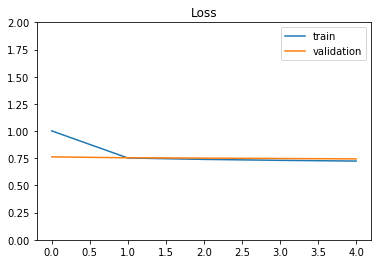

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [19]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.919
Final test MAE: 0.730


In [20]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.859
Final train MAE: 0.700


In [21]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 30), (1683, 30), (60, 64), (64,), (64, 1), (1,)]

In [22]:
# Solution: 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
user_embedding (Embedding)       (None, 1, 30)         28320       user[0][0]                       
____________________________________________________________________________________________________
item_embedding (Embedding)       (None, 1, 30)         50490       item[0][0]                       
___________________________________________________________________________________________

In [23]:
user_embeddings = weights[0]
item_embeddings = weights[1]
print("First item name from metadata:", items["name"][1])
print("Embedding vector for the first item:")
print(item_embeddings[1])
print("shape:", item_embeddings[1].shape)

First item name from metadata: Toy Story (1995)
Embedding vector for the first item:
[ 0.10110523  0.07907829  0.10156856 -0.08103411 -0.00280471 -0.08486722
  0.00580423 -0.03118018  0.07826391 -0.01865687  0.01698942  0.04938794
 -0.01015897 -0.08034275 -0.04634758  0.02811294  0.07241517  0.04609542
  0.04774655  0.0428289   0.0349216   0.05638706 -0.03260925 -0.02698584
  0.06356537 -0.05614994  0.10618012  0.02628252 -0.07170746 -0.03776284]
shape: (30,)


In [24]:
# %load solutions/similarity.py
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)

# Computes cosine similarities between x and all item embeddings
def cosine_similarities(x):
    dot_pdts = np.dot(item_embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(item_embeddings, axis=1)
    return dot_pdts / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

# Computes top_n most similar items to an idx, 
def most_similar(idx, top_n=10, mode='euclidean'):
    sorted_indexes=0
    if mode=='euclidean':
        dists = euclidean_distances(item_embeddings[idx])
        sorted_indexes = np.argsort(dists)
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], dists[idxs]))
    else:
        sims = cosine_similarities(item_embeddings[idx])
        # [::-1] makes it possible to reverse the order of a numpy
        # array, this is required because most similar items have
        # a larger cosine similarity value
        sorted_indexes = np.argsort(sims)[::-1]
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], sims[idxs]))

In [25]:
# sanity checks:
print("cosine of item 1 and item 1: "
      + str(cosine(item_embeddings[1], item_embeddings[1])))
euc_dists = euclidean_distances(item_embeddings[1])
print(euc_dists.shape)
print(euc_dists[1:5])
print()

# Test on movie 181: Return of the Jedi
print("Items closest to 'Return of the Jedi':")
for title, dist in most_similar(181, mode="cosine"):
    print(title, dist)


# We observe that the embedding is poor at representing similarities
# between movies, as most distance/similarities are very small/big 
# One may notice a few clusters though
# it's interesting to plot the following distributions
# plt.hist(euc_dists)

# The reason for that is that the number of ratings is low and the embedding
# does not automatically capture semantic relationships in that context. 
# Better representations arise with higher number of ratings, and less overfitting models

cosine of item 1 and item 1: 0.999998963554
(1683,)
[ 0.          0.37339622  0.53809768  0.31052962]

Items closest to 'Return of the Jedi':
Return of the Jedi (1983) 0.999999
Graduate, The (1967) 0.919079
L.A. Confidential (1997) 0.917611
Santa with Muscles (1996) 0.916588
As Good As It Gets (1997) 0.912666
In the Company of Men (1997) 0.91131
When We Were Kings (1996) 0.905589
Apt Pupil (1998) 0.905209
Usual Suspects, The (1995) 0.903628
Princess Bride, The (1987) 0.897912


In [26]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

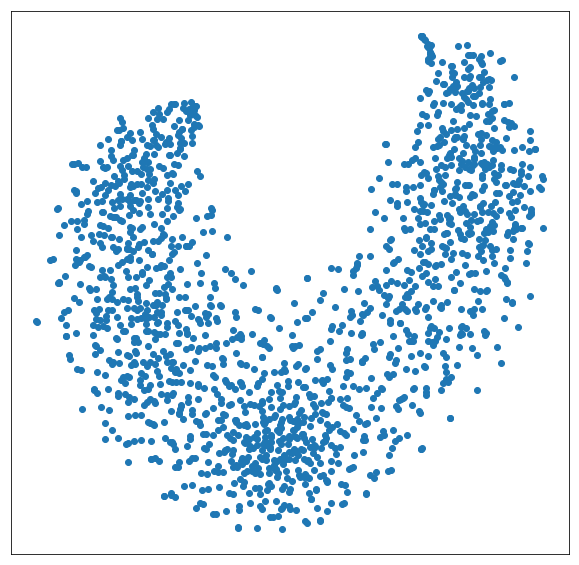

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [28]:
# transform the date (string) into an int representing the release year
parsed_dates = [int(film_date[-4:])
                for film_date in items["date"].tolist()]
print(parsed_dates[:5])

items['parsed_date'] = pd.Series(parsed_dates, index=items.index)
max_date = max(items['parsed_date'])
min_date = min(items['parsed_date'])
print(max_date, min_date)

from sklearn.preprocessing import scale

items['scaled_date'] = scale(items['parsed_date'].astype('float64'))
item_meta_train = items["scaled_date"][item_id_train]
item_meta_test = items["scaled_date"][item_id_test]
print(item_meta_train.head())

len(item_meta_train), len(item_meta_test)

[1995, 1995, 1995, 1995, 1995]
1998 1922
item_id
298    0.534131
172   -0.659161
210   -0.027418
156    0.183163
197   -1.571677
Name: scaled_date, dtype: float64


(80000, 20000)

In [29]:
items["scaled_date"].describe()

count    1.682000e+03
mean    -2.415758e-15
std      1.000297e+00
min     -4.730390e+00
25%      2.533563e-01
50%      3.937435e-01
75%      4.639372e-01
max      6.043244e-01
Name: scaled_date, dtype: float64

In [30]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = concatenate([user_vecs, item_vecs, meta_input])

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train, item_meta_train])
initial_train_preds = initial_train_preds.reshape(80000)

In [31]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, epochs=15, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/15
3s - loss: 0.9771 - val_loss: 0.7794
Epoch 2/15
2s - loss: 0.7691 - val_loss: 0.7604
Epoch 3/15
2s - loss: 0.7425 - val_loss: 0.7515
Epoch 4/15
2s - loss: 0.7287 - val_loss: 0.7440
Epoch 5/15
2s - loss: 0.7106 - val_loss: 0.7350
Epoch 6/15
3s - loss: 0.6962 - val_loss: 0.7354
Epoch 7/15
2s - loss: 0.6837 - val_loss: 0.7271
Epoch 8/15
2s - loss: 0.6742 - val_loss: 0.7304
Epoch 9/15
2s - loss: 0.6646 - val_loss: 0.7261
Epoch 10/15
2s - loss: 0.6569 - val_loss: 0.7287
Epoch 11/15
2s - loss: 0.6515 - val_loss: 0.7275
Epoch 12/15
2s - loss: 0.6467 - val_loss: 0.7215
Epoch 13/15
3s - loss: 0.6421 - val_loss: 0.7297
Epoch 14/15
3s - loss: 0.6375 - val_loss: 0.7299
Epoch 15/15
2s - loss: 0.6342 - val_loss: 0.7269
CPU times: user 1min 4s, sys: 31.4 s, total: 1min 35s
Wall time: 46 s


In [32]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test Loss: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test Loss: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test Loss: 0.953
Final test Loss: 0.718


In [33]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_movies = list(all_ratings[all_ratings["user_id"]==user_id]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))
    
    print("user "+str(user_id) +" has seen "+str(len(seen_movies)) + " movies. "+
          "Computing ratings for "+str(len(item_ids))+ " other movies")
    
    item_ids = np.array(item_ids)
    user = np.zeros_like(item_ids)
    print(user[:5])
    user[:]=user_id
    print(user[:5])
    items_meta = items["scaled_date"][item_ids].values
    
    rating_preds = model.predict([user, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:,0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["name"][movie], rating_preds[movie][0]) for movie in rec_items]

In [34]:
recommend(3)

user 3 has seen 54 movies. Computing ratings for 1627 other movies
[0 0 0 0 0]
[3 3 3 3 3]


[('Hurricane Streets (1998)', 4.6642461),
 ('A Chef in Love (1996)', 4.4620924),
 ('S.F.W. (1994)', 4.4133019),
 ('Mr. Jones (1993)', 4.3789206),
 ('Swept from the Sea (1997)', 4.2571301),
 ("Pharaoh's Army (1995)", 4.2435951),
 ('Land Before Time III: The Time of the Great Giving (1995) (V)', 4.231257),
 ('Twister (1996)', 4.1285424),
 ('Harold and Maude (1971)', 4.1196265),
 ('Office Killer (1997)', 4.1180654)]

In [35]:
import numpy as np

np.unique(rating_train)

array([1, 2, 3, 4, 5])

Random init MSE: 5.096
Random init MAE: 1.950
Train on 72000 samples, validate on 8000 samples
Epoch 1/6
3s - loss: 1.3654 - val_loss: 1.2879
Epoch 2/6
3s - loss: 1.2802 - val_loss: 1.2751
Epoch 3/6
3s - loss: 1.2612 - val_loss: 1.2692
Epoch 4/6
3s - loss: 1.2514 - val_loss: 1.2636
Epoch 5/6
3s - loss: 1.2453 - val_loss: 1.2604
Epoch 6/6
3s - loss: 1.2370 - val_loss: 1.2594
Final test MSE: 1.153
Final test MAE: 0.715


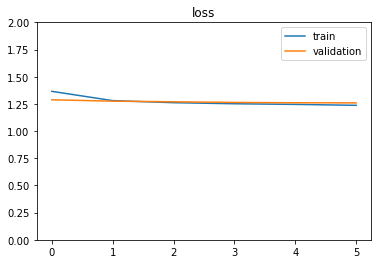

In [37]:
# %load solutions/classification.py
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 16
dense_size = 128
dropout_embedding = 0.5
dropout_hidden = 0.2

user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = concatenate([user_vecs, item_vecs, meta_input])
input_vecs = Dropout(dropout_embedding)(input_vecs)

x = Dense(dense_size, activation='relu')(input_vecs)
x = Dropout(dropout_hidden)(x)
x = Dense(dense_size, activation='relu')(x)
y = Dense(units=5, activation='softmax')(x)

model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

initial_train_preds = model.predict([user_id_train, item_id_train, item_meta_train]).argmax(axis=1) + 1
initial_train_preds = initial_train_preds.reshape(80000)
print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train - 1,
                    batch_size=64, epochs=6, validation_split=0.1,
                    shuffle=True, verbose=2)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('loss');

test_preds = model.predict([user_id_test, item_id_test, item_meta_test]).argmax(axis=1) + 1
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

In [38]:
recommend(3)

user 3 has seen 54 movies. Computing ratings for 1627 other movies
[0 0 0 0 0]
[3 3 3 3 3]


[('Black Sheep (1996)', 0.81560498),
 ("Widows' Peak (1994)", 0.79946125),
 ('Giant (1956)', 0.78428084),
 ('Titanic (1997)', 0.76062053),
 ('Adventures of Priscilla, Queen of the Desert, The (1994)', 0.75361699),
 ('My Left Foot (1989)', 0.73469055),
 ('Love! Valour! Compassion! (1997)', 0.72900897),
 ('Ghost (1990)', 0.71606022),
 ('Christmas Carol, A (1938)', 0.7130124),
 ('Face/Off (1997)', 0.70018238)]